In [1]:
using TSSM
include("time_stepper.jl");
using PyPlot
#using CPUTime

 *** OPENMP n_threads =           8


## Cubic Nonlinear Schrödinger equation

$$\mathrm{i}\frac{\partial \psi}{\partial t}=-\frac{1}{2}\frac{\partial^2\psi}{\partial x^2}+\kappa  |\psi|^2\psi,
$$ $\kappa=-1$ and initial condition
$$\psi(x,0)=\sum_{j=1}^2\frac{a_j}{\cosh(a_j(x-c_j))}\exp^{-ib_j x}$$
the parameters as below.

In [2]:
const a=[2.0, 2.0] #aplitude
const b=[1.0,-3.0] #speed
const c=[5.0,-5.0] #offset x

function soliton(x)
    (a[1]/cosh(a[1]*(x-c[1]))) * exp(-b[1]*x*1im)+
    (a[2]/cosh(a[2]*(x-c[2]))) * exp(-b[2]*x*1im)
end

soliton (generic function with 1 method)

In [3]:
cubic_coupling = -1.0
xmin=-16.0
xmax=16.0
Nx=1024

m=Schroedinger1D(Nx,xmin, xmax,cubic_coupling=cubic_coupling)
psia=wave_function(m)
psi_ref=wave_function(m)
psi=wave_function(m)

TSSM.WfSchroedinger1D{Float64}(Ptr{Void} @0x0000000004eeea30,TSSM.Schroedinger1D{Float64}(Ptr{Void} @0x0000000004ee7920))

In [4]:
include("schemes.jl");

In [5]:
include("my_helper.jl")
tend=5.0;
t0=0.0;
tols=[-5,-8,-10];
out=1;
stepmin_ex=0;
latex=1;

In [6]:
tol=1e-8
set!(psi, soliton)
x = get_nodes(m);
to_real_space!(psi);
u = get_data(psi, true);
plotdata=abs(u).^2
steps=[0.0]
mytime=[0.0]
told=0.0
nsteps=0
maxim=[0.0]


@time  for t in adaptive_time_stepper2(psi, t0, tend, 0.01, tol, palindromic_scheme_56, "AB")
      push!(steps,t-told)
      push!(mytime,t)
      told=t
      nsteps=nsteps+1
    if length(mytime)%100==0
        @printf("t=%5.3f\n",t)
    end
      if out==1
      to_real_space!(psi)
        plotdata = [plotdata abs(u).^2]
        push!(maxim,maximum(abs(u).^2))
      end
  end

t=1.093
t=2.151
t=2.480
t=3.170
t=4.274
  

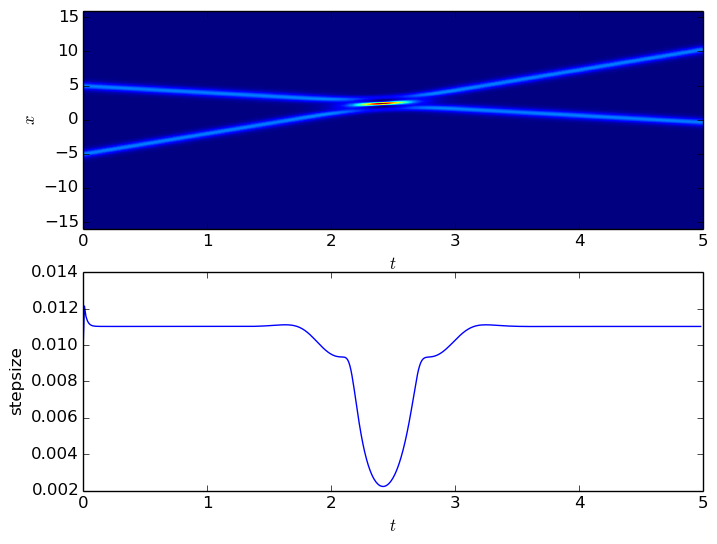

In [8]:
 using PyPlot

  figure(1)
  hold(false)
  if out==1
  subplot(2, 1, 1)
  pcolormesh(mytime,x,plotdata)
  xlabel("\$t\$")
  ylabel("\$x\$")
   # colorbar()
  axis([t0,tend,xmin,xmax])
   # title("\$|u|^2\$")
  subplot(2, 1, 2)
  end
  plot(mytime[1:end-2], steps[2:end-1])
  xlabel("\$t\$")
  ylabel("stepsize")
  savefig("step.png", bbox_inches="tight")
  #colorbar( )

In [9]:
set!(psi_ref, soliton) #compute ref_solution
@time for t in adaptive_time_stepper(psi_ref, t0, tend, 0.01, 1e-12, palindromic_scheme_56, "AB")
end

  1.803978 seconds (243.06 k allocations: 5.826 MB)


In [13]:
@printf("Method & \\# steps adaptive & \\# steps equidist & time adaptive & time equidist \\\\ \\hline \n")
maxsteps=10^6
nrep=20
for tol in tols
    for scheme in schemes
        steps_a=zeros(maxsteps)
        mytime=zeros(maxsteps)
        time_a=0.0
        nsteps_a=0
        for n in 1:nrep #average time over nrep runs
            told=0.0
            nsteps_a=0
            set!(psia, soliton)
            time_a =time_a+ @elapsed  for t in adaptive_time_stepper2(psia, t0, tend, 0.01, 10.0^tol, scheme, "AB")
                    nsteps_a=nsteps_a+1
                    steps_a[nsteps_a]=t-told
                    mytime[nsteps_a]=t
                    told=t    
            end
        end
        time_a=time_a/nrep
        stepmin=minimum(steps_a[1:nsteps_a-1])
        if out==1
            savefig!(scheme,schemes,mytime,steps_a,nsteps_a)
        end
        if stepmin_ex==1
            stepmin=calc_stepmin(psi_ref,psia,psi,scheme,soliton)
        end 
        steps=zeros(maxsteps)
        mytime=zeros(maxsteps)
        nsteps=0
        time=0.0
        for n in 1:nrep #average time over nrep runs
            told=0.0
            nsteps=0
            set!(psi, soliton)
            time = time + @elapsed  for t in equidistant_time_stepper(psi, t0, tend, stepmin, scheme, "AB")
                nsteps=nsteps+1
                steps[nsteps]=t-told
                mytime[nsteps]=t
                told=t 
            end
        end
        time=time/nrep
        if latex==1
            latextable(scheme,schemes,tol,nsteps_a,nsteps,time_a,time)
        end
    end
end

Method & \# steps adaptive & \# steps equidist & time adaptive & time equidist \\ \hline 
\texttt{Emb 4/3 AK p}, TOL = $ 10^{-5} $ & $ 313 $ & $ 1218 $ & $ 0.148 $ & $ 0.300 $ \\ 
\texttt{PP 3/4 A}, TOL = $ 10^{-5} $ & $ 487 $ & $ 1945 $ & $ 0.235 $ & $ 0.343 $ \\ 
\texttt{PP 5/6 A}, TOL = $ 10^{-5} $ & $ 168 $ & $ 528 $ & $ 0.180 $ & $ 0.224 $ \\ \hline 
\texttt{Emb 4/3 AK p (defect)}, TOL = $ 10^{-5} $ & $ 294 $ & $ 1148 $ & $ 0.215 $ & $ 0.220 $ \\ 
\texttt{PP 3/4 A (defect)}, TOL = $ 10^{-5} $ & $ 487 $ & $ 1945 $ & $ 0.172 $ & $ 0.256 $ \\ 
\texttt{PP 5/6 A (defect)}, TOL = $ 10^{-5} $ & $ 210 $ & $ 815 $ & $ 0.188 $ & $ 0.295 $ \\ \hline 
\texttt{Emb 4/3 AK p}, TOL = $ 10^{-8} $ & $ 1751 $ & $ 6850 $ & $ 0.615 $ & $ 1.219 $ \\ 
\texttt{PP 3/4 A}, TOL = $ 10^{-8} $ & $ 2753 $ & $ 11000 $ & $ 0.772 $ & $ 1.366 $ \\ 
\texttt{PP 5/6 A}, TOL = $ 10^{-8} $ & $ 565 $ & $ 2251 $ & $ 0.428 $ & $ 0.812 $ \\ \hline 
\texttt{Emb 4/3 AK p (defect)}, TOL = $ 10^{-8} $ & $ 1661 $ & $ 6497 $ & $

In [8]:
    nstep=10000
    tol=1e-5
    dt=0.01
    @printf("Method & %d steps without errorestimator & %d steps with errorestimator\\\\ \\hline \n",nstep,nstep)
    for scheme in schemes
        set!(psi, soliton)
        time1 = @elapsed  for t in 1:nstep
            step!(psi, dt, scheme,"AB")
        end
        psi2=clone(psi)
        time2 = @elapsed  for t in 1:nstep
        if typeof(scheme)==PalindromicScheme
           copy!(psi, psi2)
           step_palindromic!(psi, psi2, dt, scheme.scheme, "AB")
           err = 0.5*distance(psi, psi2)/tol
        end
        if typeof(scheme)==EmbeddedScheme
           copy!(psi, psi2)
           step_embedded!(psi, psi2, dt, scheme.scheme1, scheme.scheme2, "AB")
           err = distance(psi, psi2)/tol
        end  
        if typeof(scheme)==DefectBasedScheme
            step_defect_based!(psi, psi2, dt, scheme.scheme, "AB")
            err = dt*norm(psi2)/(scheme.order+1)/tol
        end
    end
        if scheme==schemes[1]
            @printf("\\texttt{Emb 4/3 AK p} & \$ %5.3f \$ & \$ %5.3f \$ \\\\ \n",time1,time2)
        end
        if scheme==schemes[2]
            @printf(    "\\texttt{PP 3/4 A} & \$ %5.3f \$ & \$ %5.3f \$ \\\\ \n",time1,time2)
        end
        if scheme==schemes[3]
        @printf(    "\\texttt{PP 5/6 A} & \$ %5.3f \$ & \$ %5.3f \$ \\\\ \\hline \n",time1,time2)
        end
        if scheme==schemes[4]
            @printf("\\texttt{Emb 4/3 AK p (defect)} & \$ %5.3f \$ & \$ %5.3f \$ \\\\ \n",time1,time2)
        end
        if scheme==schemes[5]
            @printf(    "\\texttt{PP 3/4 A (defect)} & \$ %5.3f \$ & \$ %5.3f \$ \\\\ \n",time1,time2)
        end
        if scheme==schemes[6]
        @printf(    "\\texttt{PP 5/6 A (defect)} & \$ %5.3f \$ & \$ %5.3f \$ \\\\ \\hline \n",time1,time2)
        end
    end

Method & 10000 steps without errorestimator & 10000 steps with errorestimator\\ \hline 
\texttt{Emb 4/3 AK p} & $ 2.733 $ & $ 3.687 $ \\ 
\texttt{PP 3/4 A} & $ 1.647 $ & $ 3.013 $ \\ 
\texttt{PP 5/6 A} & $ 4.395 $ & $ 7.794 $ \\ \hline 
\texttt{Emb 4/3 AK p (defect)} & $ 2.742 $ & $ 6.006 $ \\ 
\texttt{PP 3/4 A (defect)} & $ 1.654 $ & $ 3.665 $ \\ 
\texttt{PP 5/6 A (defect)} & $ 4.374 $ & $ 9.243 $ \\ \hline 


In [9]:
t0 = 0
tend = 1
cubic_coupling = -1.0
xmin=-16.0
xmax=16.0
Nx=1024

const a1 = 2
const b1 = 1
const c1 = 0
function soliton(x, t)
    h = (a1^2 - b1^2)/2*t - b1*x
    (a1./cosh(a1*(b1*t+x-c1))).*exp(1im*h) 
end 

m=Schroedinger1D(Nx,xmin, xmax,cubic_coupling=cubic_coupling)
for scheme in [schemes[2],schemes[5],] 
psi = wave_function(m)
psi_ref = wave_function(m)
set!(psi, soliton, t0)        # initial data at t=t0
set!(psi_ref, soliton, tend)
    local_orders(psi, soliton, t0, tend-t0, scheme, operator_sequence="AB", rows=12)
end
;

             dt         err      p         err      p
------------------------------------------------------
  1   1.000e+00   1.174e+00          1.159e+00
  2   5.000e-01   3.684e-01   1.67   2.704e-01   2.10
  3   2.500e-01   8.816e-02   2.06   4.521e-02   2.58
  4   1.250e-01   1.357e-02   2.70   5.133e-03   3.14
  5   6.250e-02   1.336e-03   3.34   3.562e-04   3.85
  6   3.125e-02   1.000e-04   3.74   1.549e-05   4.52
  7   1.563e-02   6.708e-06   3.90   5.165e-07   4.91
  8   7.813e-03   4.294e-07   3.97   1.612e-08   5.00
  9   3.906e-03   2.702e-08   3.99   5.022e-10   5.00
 10   1.953e-03   1.692e-09   4.00   1.568e-11   5.00
 11   9.766e-04   1.058e-10   4.00   4.897e-13   5.00
 12   4.883e-04   6.612e-12   4.00   1.556e-14   4.98
             dt         err      p         err      p
------------------------------------------------------
  1   1.000e+00   1.174e+00          1.116e+00
  2   5.000e-01   3.684e-01   1.67   3.308e-01   1.76
  3   2.500e-01   8.816e-02   2.06   6.8